In [1]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import sqlite3 
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re

# %%time 
#from pymystem3 import Mystem

In [2]:
!git clone https://github.com/kanekomasahiro/gp_debias
!cd ./gp_debias; mkdir d; cd d; git clone https://github.com/uclanlp/gn_glove.git
!paste ./gp_debias/d/gn_glove/wordlist/female_word_file.txt ./gp_debias/d/gn_glove/wordlist/male_word_file.txt > ./gp_debias/wordlist/gender_pair.tsv 
!cp -r ./gp_debias/d/gn_glove/SemBias ./gp_debias/
!ls ./gp_debias

Cloning into 'gn_glove'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 199 (delta 2), reused 6 (delta 2), pack-reused 193
Receiving objects: 100% (199/199), 67.78 KiB | 207.00 KiB/s, done.
Resolving deltas: 100% (88/88), done.
d	     eval_word_embeddings.py  LICENSE	 run.sh   src
download.sh  hyperparams	      README.md  SemBias  wordlist


In [ ]:
# export save_dir=src/debiased_glove
# export debiased_dir=debiased_embeddings

# mkdir -p src/glove_model
# mkdir -p src/debiased_glove

# python src/train.py glove
# python src/eval.py glove

# mkdir -p $debiased_dir
# mv $save_dir/gender_debiased.bin $debiased_dir/gp-glove\.bin
# mv $save_dir/gender_debiased.txt $debiased_dir/gp-glove\.txt
# rm -r src/debiased_glove

In [3]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
from numpy import dot
from numpy.linalg import norm
from gensim.models import KeyedVectors
import argparse


SEM_BIAS = './SemBias/SemBias'

# emb = KeyedVectors.load_word2vec_format('/media/pavel/tmp/glove/vectors.txt',
#                                             binary=False)


def load_words_pair(words, model, gender_v, w1, w2, categ):
    """loads pair of words into dict words"""
    v1 = model[w1]
    v2 = model[w2]
    score1 = dot(gender_v, v1)/(norm(gender_v)*norm(v1))
    score2 = dot(gender_v, v2)/(norm(gender_v)*norm(v2))
    words[w1] = (score1, categ, norm(v1))
    words[w2] = (score2, categ, norm(v2))
    return


def eval_bias_analogy(model):
    bias_analogy_f = open(SEM_BIAS)

    definition_num = 0
    none_num = 0
    stereotype_num = 0
    total_num = 0
    sub_definition_num = 0
    sub_none_num = 0
    sub_stereotype_num = 0
    sub_size = 40
    words = {}
    uni_words = []

    sub_start = -(sub_size - sum(1 for line in open(SEM_BIAS)))

    gender_v = model['he'] - model['she']
    cnt = 0
    for sub_idx, l in enumerate(bias_analogy_f):
        cnt += 1
        if cnt % 200 == 0:
            print(f"Processing line {cnt}")
        l = l.strip().split()
        max_score = -100
        for i, word_pair in enumerate(l):
            word_pair = word_pair.split(':')
            pre_v = model[word_pair[0]] - model[word_pair[1]]
            score = dot(gender_v, pre_v)/(norm(gender_v)*norm(pre_v))
            if score > max_score:
                max_idx = i
                max_score = score
            if word_pair[0] not in uni_words:
                uni_words.append(word_pair[0])
            if word_pair[1] not in uni_words:
                uni_words.append(word_pair[1])
            load_words_pair(words, model, gender_v, word_pair[0], word_pair[1], i)
        if max_idx == 0:
            definition_num += 1
            if sub_idx >= sub_start:
                sub_definition_num += 1
        elif max_idx == 1 or max_idx == 2:
            none_num += 1
            if sub_idx >= sub_start:
                sub_none_num += 1
        elif max_idx == 3:
            stereotype_num += 1
            if sub_idx >= sub_start:
                sub_stereotype_num += 1
        total_num += 1
    if definition_num == 0:
        print('definition: 0')
    else:
        print('definition: {}'.format(definition_num / total_num))
    if stereotype_num == 0:
        print('stereotype: 0')
    else:
        print('stereotype: {}'.format(stereotype_num / total_num))
    if none_num == 0:
        print('none: 0')
    else:
        print('none: {}'.format(none_num / total_num))

    if sub_definition_num == 0:
        print('sub definition: 0')
    else:
        print('sub definition: {:.5f}'.format(sub_definition_num / sub_size))
    if sub_stereotype_num == 0:
        print('sub stereotype: 0')
    else:
        print('substereotype: {:.5f}'.format(sub_stereotype_num / sub_size))
    if sub_none_num == 0:
        print('sub none: 0')
    else:
        print('sub none: {:.5f}'.format(sub_none_num / sub_size))
    return uni_words, words

# uni, w = eval_bias_analogy(emb)


# emb2 = KeyedVectors.load_word2vec_format('/media/pavel/tmp/glove/vectors300.txt',
#                                             binary=False)

J=\sum_{i, j=1}^{V}f\left(𝑋_{i j}\right)(w^{T}_{i}\tilde{w}_{j} + b_{i} + \tilde{b}_{j} - \log{𝑋}_{ij})^{2}

\begin{align*}
sum i,j (a+b)^2 = a^2+2ab+b^2
\end{align*}

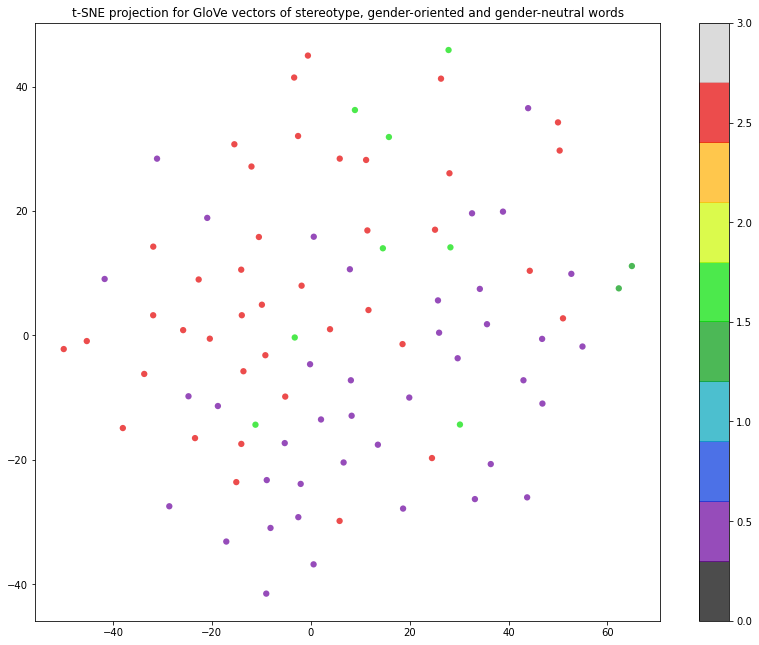

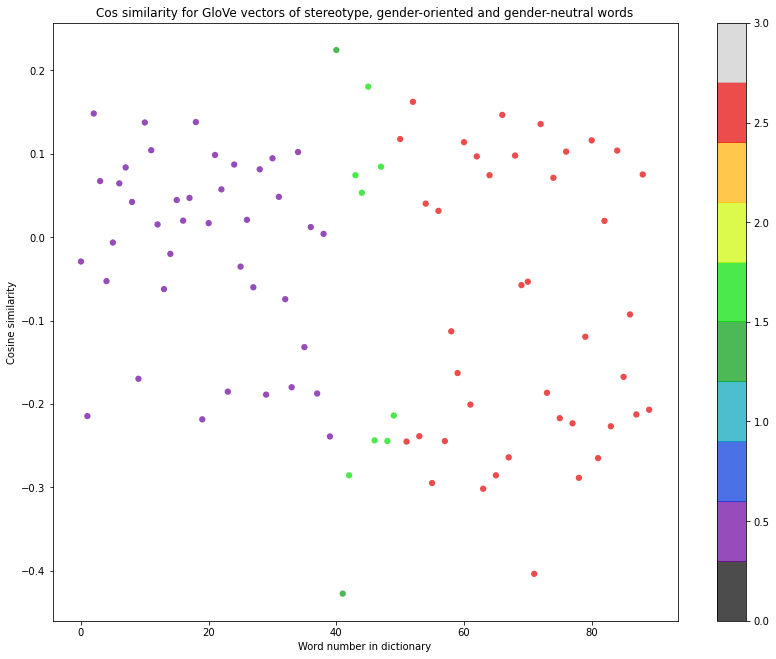

In [4]:
goriented = ['he','she', 'businesswoman', 'businessman', 'man', 'bishop', 'congresswoman', 'congressman', 'waitress', 'housewife']
w100 = np.array([emb[s] for s in uni[:100]])
gender_v = emb['he'] - emb['she']

ster = [s for s in uni if w[s][1] == 3]
neut = [s for s in uni if w[s][1] == 0]
mywords = ster + goriented + neut[:40]

y = np.array([dot(gender_v, v)/(norm(gender_v) * norm(v)) for v in [emb[s] for s in mywords[:90]]])
X = np.array([n for n,_ in enumerate(mywords[:90])])
embs = np.array([emb[s] for s in mywords[:90]])


col = [0.5 if i < 40 else 1.4 if i<42 else 1.5 if i<50 else 2.5 for i in range(90)]
m = ['stereotype' if i < 40 else 'gender-oriented' if i < 50 else 'gender-neutral' for i in range(90)]
nums = list(range(90))

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(embs)

plt.figure(figsize=(14,11))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=col, vmin=0, vmax=3,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('t-SNE projection for GloVe vectors of stereotype, gender-oriented and gender-neutral words');


plt.figure(figsize=(14,11))
plt.ylabel('Cosine similarity')
plt.xlabel('number in dictionary')
plt.scatter(nums, y, c=col, vmin=0, vmax=3,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('Cos similarity for GloVe vectors of stereotype, gender-oriented and gender-neutral words');

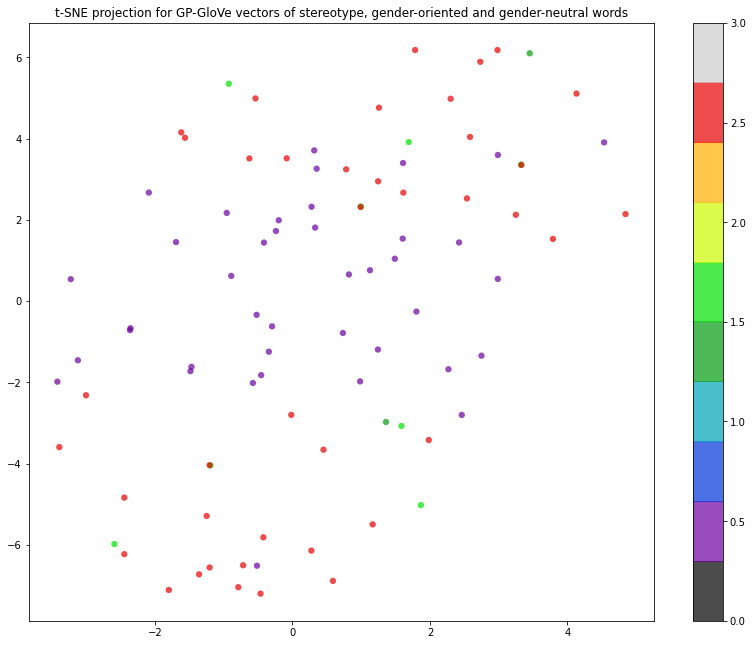

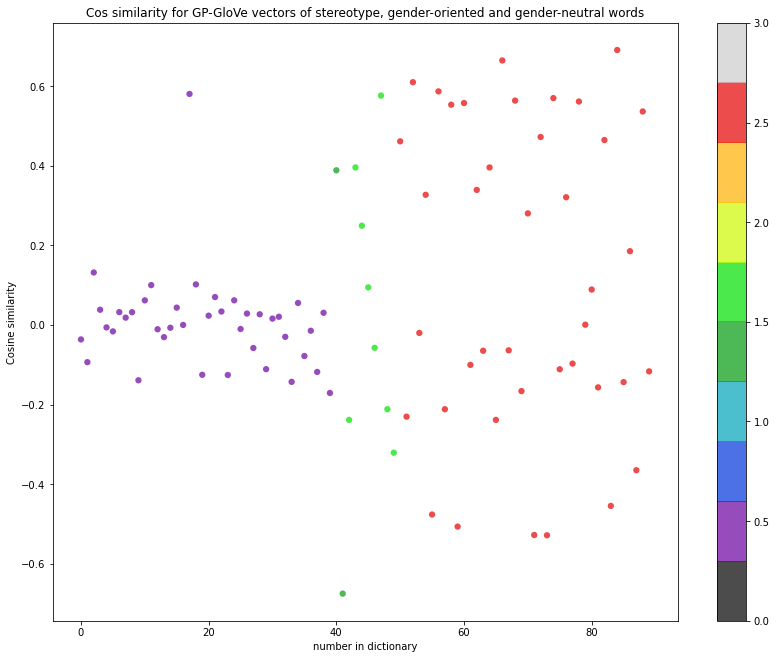

In [6]:

goriented = ['he','she', 'businesswoman', 'businessman', 'man', 'bishop', 'congresswoman', 'congressman', 'waitress', 'housewife']
w100 = np.array([emb2[s] for s in uni[:100]])
gender_v = emb2['he'] - emb2['she']

ster = [s for s in uni if w[s][1] == 3]
neut = [s for s in uni if w[s][1] == 0]
mywords = ster + goriented + neut[:40]

y = np.array([dot(gender_v, v)/(norm(gender_v) * norm(v)) for v in [emb2[s] for s in mywords[:90]]])
X = np.array([n for n,_ in enumerate(mywords[:90])])
embs = np.array([emb2[s] for s in mywords[:90]])


col = [0.5 if i < 40 else 1.4 if i<42 else 1.5 if i<50 else 2.5 for i in range(90)]
m = ['stereotype' if i < 40 else 'gender-oriented' if i < 50 else 'gender-neutral' for i in range(90)]
nums = list(range(90))

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(embs)

plt.figure(figsize=(14,11))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=col, vmin=0, vmax=3,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('t-SNE projection for GP-GloVe vectors of stereotype, gender-oriented and gender-neutral words');


plt.figure(figsize=(14,11))
plt.ylabel('Cosine similarity')
plt.xlabel('number in dictionary')
plt.scatter(nums, y, c=col, vmin=0, vmax=3,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('Cos similarity for GP-GloVe vectors of stereotype, gender-oriented and gender-neutral words');

gp_debias/embeddings/glove.txt


var ratio for main components  [0.10952563 0.17475112 0.23408796 0.28740585 0.33198287 0.36845381
 0.40046785 0.42631313 0.45083474 0.47406624 0.49649712 0.51809978
 0.53826178 0.55764362 0.57619112 0.59464685 0.61131469 0.62663778
 0.64175656 0.65591491 0.66939077 0.68257117 0.69546582 0.70786149
 0.72008274 0.73168414 0.74279857 0.75305879 0.76319638 0.77302415
 0.78243858 0.79136788 0.80019897 0.80870172 0.81705114 0.82494432
 0.83263266 0.83999684 0.84709559 0.85401676 0.86079424 0.86735559
 0.87372728 0.87979081 0.88544157 0.89102414 0.89654046 0.9016527 ]


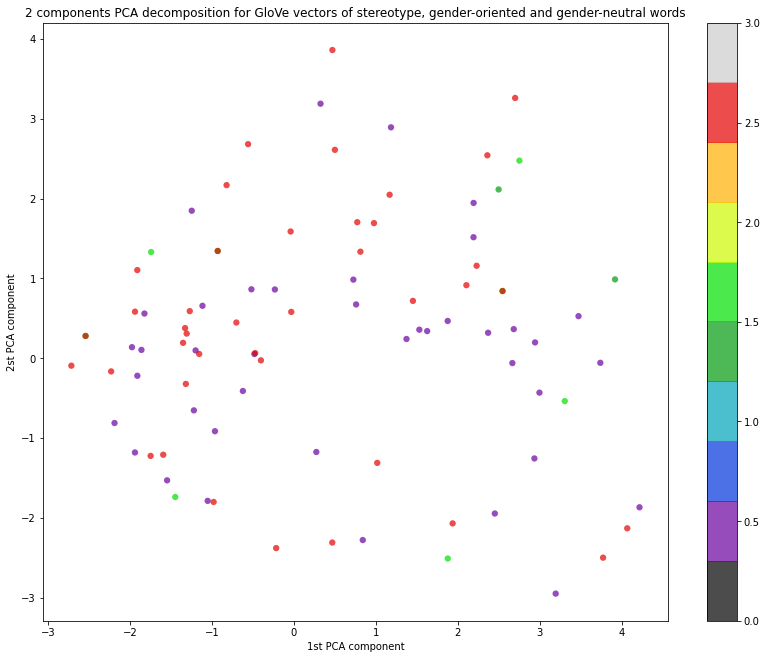

In [65]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import datasets


def get_data():
    y = np.array([dot(gender_v, v)/(norm(gender_v) * norm(v)) for v in [emb[s] for s in mywords[:90]]])
    X = [emb[s] for s in mywords[:100]]
    return X, y, col


def min_cumsum_index(arr):
    cum_sum = np.cumsum(arr)
    zeros_indexes = np.where(cum_sum[:] > .9)[0]
    if not zeros_indexes.size:
        return None, None
    return np.min(zeros_indexes)


def test_pca():
    X, y, cc = get_data()
    pca = PCA().fit(X)
    idx = min_cumsum_index(pca.explained_variance_ratio_)
    cum_sum = np.cumsum(pca.explained_variance_ratio_)
    e1 = pca.components_[0]
    e2 = pca.components_[1]
    x1 = [dot(e1, v) for v in X]
    x2 = [dot(e2, v) for v in X]
    plt.figure(figsize=(14,11))
    plt.xlabel('1st PCA component')
    plt.ylabel('2nd PCA component')
    plt.scatter(x1, x2, c=cc, vmin=0, vmax=3,
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.colorbar()
    plt.title('2 components PCA decomposition for GloVe vectors of stereotype, gender-oriented and gender-neutral words');
#     plt.figure(figsize=(10,7))
#     plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
#     plt.xlabel('Number of components')
#     plt.ylabel('Total explained variance')
#     plt.xlim(0, 63)
#     plt.yticks(np.arange(0, 1.1, 0.1))
#     plt.axvline(21, c='b')
#     plt.axhline(0.9, c='r')
#     plt.show()
    return pca
    
pca = test_pca() 

In [18]:
!gdown --id '1v82WF43w-lE-vpZd0JC1K8WYZQkTy_ii'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1v82WF43w-lE-vpZd0JC1K8WYZQkTy_ii
To: /content/GN-GloVe-L1-0.8-0.8.txt.zip
100% 369M/369M [00:05<00:00, 67.1MB/s]


In [19]:
!cp -r ./gp_debias/d/gn_glove/SemBias ./gp_debias/

In [26]:
!gdown --id  "12VK2-BpLAg_-VPVl_wcLBZbzd9wcwyqN"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=12VK2-BpLAg_-VPVl_wcLBZbzd9wcwyqN
To: /content/gp-glove.txt
100% 1.98G/1.98G [00:30<00:00, 65.3MB/s]


In [27]:
!cd gp_debias; python eval_word_embeddings.py -i /content/gp-glove.txt -g /content/gp_debias/SemBias/SemBias

definition: 0.8431818181818181
stereotype: 0.07954545454545454
none: 0.07727272727272727
sub definition: 0.65000
substereotype: 0.15000
sub none: 0.20000


In [20]:
#Generating emb...
#Start generating
#src/eval.py:95: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
#  inputs = torch.split(torch.stack([torch.FloatTensor(w2v[word]) for word in w2v.vocab.keys()]), 1024)
#SemBias
#definition: 0.8386363636363636
#stereotype: 0.08181818181818182
#none: 0.07954545454545454
#sub definition: 0.625
#sub stereotype: 0.15
#sub none: 0.225
#Saving emb...

In [4]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
from numpy import dot
from numpy.linalg import norm
from gensim.models import KeyedVectors
import argparse
import time
import pathlib
from pathlib import Path


SEM_BIAS = './SemBias/SemBias'
GP_GN = '/media/pavel/tmp/glove/gp_gn.txt'
GP = '/media/pavel/tmp/glove/vectors300.txt'
GLOVE = '/media/pavel/tmp/glove/gp_glove.txt'
GOOGLE_ANT = '/media/pavel/tmp/glove/google_anthology_ds.txt'
GP_GLOVE = '/media/pavel/tmp/glove/gp_glove.txt'
RG65 = '/media/pavel/tmp/glove/EN-RG-65.txt'
WSA = '/media/pavel/tmp/glove/WS_A.csv'
WSB = '/media/pavel/tmp/glove/WS_B.csv'
MTURK = '/media/pavel/tmp/glove/MTurk.csv'
RW = '/media/pavel/tmp/glove/RW2034.csv'
MEN = '/media/pavel/tmp/glove/MEN3000.csv'
SIMLEX = '/media/pavel/tmp/glove/SimLex.txt'
SEM_EVAL = '/media/pavel/tmp/glove/SemEval'

In [5]:
emb_gn = KeyedVectors.load_word2vec_format(GP_GLOVE, binary=False)

In [10]:
def get_vocabulary(fn = GLOVE):
    with open(fn, "r") as f:
        vocab = [line.lower().split()[0] for line in f]
    return vocab[1:]


def get_anthology_ds(fn = GOOGLE_ANT):
    with open(fn, "r") as f:
        vocab = [line.lower().split() for line in f if line[0] != ':']
    return vocab


def get_semeval(path = SEM_EVAL):
    fnames = Path(path).rglob("*.txt")
    full_lst = []
    for n in fnames:
        pth = str(n)
        with open(pth, "r") as f:
            vocab = [line.replace('"', "").lower().split() for line in f if line[0] != '#']
        full_lst = full_lst + vocab
    res = [[p[0].split(':')] + [p[1].split(':')]+[p[2].split(':')] + [p[3].split(':')] for p in full_lst]
    return res

def cosine_sim(v, w):
    """cosine similarity"""
    return np.dot(w, v)/((np.linalg.norm(w)) * (np.linalg.norm(v) + 0.000001))


def find_simi(lst, a, b, c, vocab, emb):
    """find argmax using 3COSADD method"""
    v1 = b - a + c
    amax = 0.
    result = ""
    for w2 in vocab:
        if w2 not in lst:
            sim = cosine_sim(emb[w2], v1)
            if sim > amax:
                result = w2
                amax = sim
    return result, amax

#vocab = get_vocabulary()
anthologies = get_anthology_ds()
vocab_gp = get_vocabulary(fn = GP_GLOVE)



In [12]:
# def cosmul_sim(w, a, b, c, to_do, eps = 0.01):
#     """ 3COSMUL similarity - example #sim = cosmul_sim(emb[w2], a,b,c, false)"""
#     if to_do:
#         print(cos(w, c), cos(w, b), cos(w, a))
#     c1, c2, c3 = cos(w, c), cos(w, b), cos(w, a)
#     if to_do:
#         print(c1, c2, c3, (c1 * c2)/(c3 + eps))
#     if c3 < 0:
#         eps = -0.01
#     return c1 * c2/(c3 + eps)

def cosine_sim(v, w, eps = 0.001):
    """cosine similarity"""
    return np.dot(w, v)/((np.linalg.norm(w)+0.000001) * (np.linalg.norm(v)+eps))


def find_simi(lst, a, b, c, vocab, emb):
    """find argmax using 3COSADD method"""
    v1 = b - a + c
    amax = 0.
    result = ""
    for w2 in vocab:
        if w2 not in lst:
            sim = cosine_sim(emb[w2], v1)
            if sim > amax:
                result = w2
                amax = sim
    return result, amax


def calculate_acc_for_analogies(anthologies, emb_gn, vocab_gn):
    """ check overall accuracy of anthologies """
    corrects = 0
    total = 0
    a, b, c = "", "", ""
    emb1, emb2, emb3 = [0], [0], [0]
    for tup in anthologies:
        e1 = emb_gn[tup[0]] if a != tup[0] else emb1
        e2 = emb_gn[tup[1]] if b != tup[1] else emb2
        e3 = emb_gn[tup[2]] if c != tup[2] else emb3
        word, sim = find_simi(tup[:3], e1, e2, e3, vocab_gn, emb_gn)
        if word == tup[3]:
            corrects +=1
        total +=1
        emb1, emb2, emb3 = e1, e2, e3
        a, b, c = tup[0], tup[1], tup[2]
        if total % 50 == 0:
            print(total, *tup, word, sim, "actual:", tup[3], corrects/total)
    return corrects, total

print(f"GN GLOVE check")
corrects, total = calculate_acc_for_analogies(anthologies, emb_gn, vocab_gn)
print(f"Final score: {corrects/total} {corrects} {total}")

GN GLOVE check
50 bangkok thailand hanoi vietnam vietnam 0.6850367252897471 actual: vietnam 0.96
100 berlin germany oslo norway norway 0.7555886964501195 actual: norway 0.97
150 cairo egypt baghdad iraq iraq 0.7404456221084577 actual: iraq 0.96
200 havana cuba islamabad pakistan pakistan 0.7136669378448934 actual: pakistan 0.955
250 islamabad pakistan rome italy italy 0.7133663294290572 actual: italy 0.956
300 london england berlin germany germany 0.6600025102687568 actual: germany 0.96
350 moscow russia kabul afghanistan afghanistan 0.7697258532627865 actual: afghanistan 0.9628571428571429
400 paris france tokyo japan japan 0.7510880087797088 actual: japan 0.9625
450 stockholm sweden canberra australia australia 0.6283671971970209 actual: australia 0.9644444444444444
500 tokyo japan moscow russia russia 0.804189515815529 actual: russia 0.964
550 accra ghana apia samoa samoa 0.587528527154653 actual: samoa 0.9636363636363636
600 algiers algeria belgrade serbia serbia 0.7395836943844512

4450 tehran iran tunis tunisia tunisia 0.7079895477371879 actual: tunisia 0.9539325842696629
4500 thimphu bhutan algiers algeria algeria 0.6406752017206051 actual: algeria 0.9544444444444444
4550 tirana albania bangkok thailand thailand 0.7156899977305886 actual: thailand 0.9542857142857143
4600 tokyo japan budapest hungary hungary 0.7537721199125148 actual: hungary 0.9547826086956521
4650 tunis tunisia abuja nigeria nigeria 0.6735391874116704 actual: nigeria 0.9550537634408602
4700 vaduz liechtenstein baku azerbaijan azerbaijan 0.6650787422164804 actual: azerbaijan 0.955531914893617
4750 valletta malta brussels belgium belgium 0.6951510295571067 actual: belgium 0.9555789473684211
4800 vientiane laos yerevan armenia armenia 0.5864594123055564 actual: armenia 0.9558333333333333
4850 vilnius lithuania athens greece greece 0.7761045093552832 actual: greece 0.9562886597938144
4900 warsaw poland bishkek kyrgyzstan kyrgyzstan 0.6503349714256641 actual: kyrgyzstan 0.9567346938775511
4950 wind

8650 man woman nephew niece niece 0.7793577951133991 actual: niece 0.8048554913294798
8700 policeman policewoman uncle aunt grandfather 0.547061432097489 actual: aunt 0.8050574712643678
8750 son daughter grandson granddaughter granddaughter 0.8967902690788242 actual: granddaughter 0.8054857142857142
8800 stepbrother stepsister policeman policewoman undercover 0.43563202696466263 actual: policewoman 0.8060227272727273
8850 uncle aunt brothers sisters sisters 0.7337796051554695 actual: sisters 0.8063276836158192
8900 amazing amazingly usual usually fairly 0.4353555396154974 actual: usually 0.803932584269663
8950 calm calmly rapid rapidly industrialization 0.43402225290446295 actual: rapidly 0.8005586592178771
9000 complete completely infrequent infrequently totally 0.44946878086069386 actual: infrequently 0.7973333333333333
9050 efficient efficiently usual usually occasionally 0.4133883456542893 actual: usually 0.794696132596685
9100 free freely rapid rapidly rapidly 0.48413528818485485 

12800 strange strangest tall tallest tallest 0.5075045533868683 actual: tallest 0.706328125
12850 strong strongest hot hottest billboard 0.516695918773027 actual: hottest 0.7059922178988327
12900 tall tallest weird weirdest rarest 0.370394211672587 actual: weirdest 0.7055038759689922
12950 tasty tastiest lucky luckiest igbinedion 0.41092592835639336 actual: luckiest 0.7044015444015445
13000 weak weakest big biggest biggest 0.48262939118394593 actual: biggest 0.7028461538461539
13050 weird weirdest simple simplest simplest 0.43059809798332216 actual: simplest 0.7022988505747126
13100 young youngest dark darkest darker 0.4597670122949482 actual: darkest 0.7012977099236641
13150 code coding see seeing perceptual 0.36208053735609247 actual: seeing 0.6999239543726236
13200 debug debugging increase increasing increased 0.61995257558958 actual: increasing 0.6991666666666667
13250 decrease decreasing vanish vanishing vanishes 0.5576561961973672 actual: vanishing 0.6988679245283019
13300 discov

17000 slowing slowed dancing danced dance 0.6332133366558019 actual: danced 0.7054117647058824
17050 spending spent increasing increased increased 0.615547068293956 actual: increased 0.7051026392961877
17100 striking struck screaming screamed screams 0.4855845047339877 actual: screamed 0.7047953216374269
17150 taking took walking walked walk 0.6018770967001634 actual: walked 0.7041399416909621
17200 thinking thought hitting hit hit 0.6038662563281537 actual: hit 0.7038953488372093
17250 vanishing vanished running ran ran 0.5933227972472171 actual: ran 0.7036521739130435
17300 walking walked swimming swam swam 0.5411557464052763 actual: swam 0.7033526011560693
17350 banana bananas color colors colour 0.6522338226554668 actual: colors 0.7027089337175793
17400 bird birds machine machines machines 0.6754873897140109 actual: machines 0.7032183908045977
17450 bottle bottles bird birds birds 0.640972884498438 actual: birds 0.7033810888252149
17500 car cars finger fingers fingers 0.65270655923

In [ ]:
corrects, total = 13710, 19544

In [12]:
def calculate_acc_for_sem_analogies(anthologies, emb_gn, vocab_gn):
    """ check accuracy of sem anthologies
        initial accuracy was taken from row '8800 ...' of previous cell
    """
    prev_result = "8800 stepbrother stepsister policeman policewoman undercover 0.43563202696466263 actual: policewoman 0.8060227272727273"
    print(prev_result)
    total = 8800
    corrects = int(0.8060227272727273 * total)
    a, b, c = "", "", ""
    emb1, emb2, emb3 = [0], [0], [0]
    for tup in anthologies[8800:8867]:
        # saving vectors to speed up computation
        e1 = emb_gn[tup[0]] if a != tup[0] else emb1
        e2 = emb_gn[tup[1]] if b != tup[1] else emb2
        e3 = emb_gn[tup[2]] if c != tup[2] else emb3
        # trying to find similar word as argmax(3COSADD(e2-e1+e3, E(w))) for all words w in vocab except tup[:3]
        word, sim = find_simi(tup[:3], e1, e2, e3, vocab_gn, emb_gn)
        if word == tup[3]:
            corrects +=1
        total +=1
        emb1, emb2, emb3 = e1, e2, e3
        a, b, c = tup[0], tup[1], tup[2]
        if total % 50 == 0:
            print(total, *tup, word, sim, "actual:", tup[3], corrects/total)
    return corrects , total

print(f"GP-GLOVE check")
sem_corrects, sem_total = calculate_acc_for_sem_analogies(anthologies, emb_gn, vocab_gp)
print(f"GP-GLOVE accuracy of sem anthologies: {sem_corrects/sem_total} {sem_corrects} {sem_total}")
syn_acc = (corrects - sem_corrects) / (total - sem_total)
print(f"GP-GLOVE accuracy of syn anthologies: {syn_acc} correct answers: {corrects - sem_corrects}")
print(f"GP-GLOVE overal accuracy for anthologies: {corrects/ total} ")

GP-GLOVE check
50 bangkok thailand hanoi vietnam vietnam 0.6852618387306538 actual: vietnam 0.96
100 berlin germany oslo norway norway 0.7558395413878118 actual: norway 0.97
150 cairo egypt baghdad iraq iraq 0.7406891415824357 actual: iraq 0.96
200 havana cuba islamabad pakistan pakistan 0.7138978622490665 actual: pakistan 0.955
250 islamabad pakistan rome italy italy 0.7136088309374902 actual: italy 0.956
300 london england berlin germany germany 0.6602103637332724 actual: germany 0.96
350 moscow russia kabul afghanistan afghanistan 0.769988647718658 actual: afghanistan 0.9628571428571429
400 paris france tokyo japan japan 0.7513277542570821 actual: japan 0.9625
450 stockholm sweden canberra australia australia 0.628575880022136 actual: australia 0.9644444444444444
500 tokyo japan moscow russia russia 0.8044472692129395 actual: russia 0.964
550 accra ghana apia samoa samoa 0.5877346563186038 actual: samoa 0.9636363636363636
600 algiers algeria belgrade serbia serbia 0.7398251668135005

4450 tehran iran tunis tunisia tunisia 0.7082459182826621 actual: tunisia 0.9539325842696629
4500 thimphu bhutan algiers algeria algeria 0.6409014922867984 actual: algeria 0.9544444444444444
4550 tirana albania bangkok thailand thailand 0.715937064952442 actual: thailand 0.9542857142857143
4600 tokyo japan budapest hungary hungary 0.754029500369454 actual: hungary 0.9547826086956521
4650 tunis tunisia abuja nigeria nigeria 0.6737669925204443 actual: nigeria 0.9550537634408602
4700 vaduz liechtenstein baku azerbaijan azerbaijan 0.6652971746443872 actual: azerbaijan 0.955531914893617
4750 valletta malta brussels belgium belgium 0.6953872663888939 actual: belgium 0.9555789473684211
4800 vientiane laos yerevan armenia armenia 0.5866625921787115 actual: armenia 0.9558333333333333
4850 vilnius lithuania athens greece greece 0.7763536235183113 actual: greece 0.9562886597938144
4900 warsaw poland bishkek kyrgyzstan kyrgyzstan 0.6505633979119237 actual: kyrgyzstan 0.9567346938775511
4950 windho

8650 man woman nephew niece niece 0.7796965183785336 actual: niece 0.8048554913294798
8700 policeman policewoman uncle aunt grandfather 0.547278833644874 actual: aunt 0.8050574712643678
8750 son daughter grandson granddaughter granddaughter 0.8971724450523073 actual: granddaughter 0.8054857142857142
8800 stepbrother stepsister policeman policewoman undercover 0.435782673159055 actual: policewoman 0.8060227272727273
8850 uncle aunt brothers sisters sisters 0.7340335067650923 actual: sisters 0.8063276836158192


NameError: name 'sem_corrects' is not defined

In [17]:
print(f"GP-GLOVE check")
sem_corrects, sem_total = calculate_acc_for_sem_analogies(anthologies, emb_gn, vocab_gp)
print(f"GP-GLOVE accuracy of sem anthologies: {sem_corrects/sem_total} {sem_corrects} {sem_total}")
syn_acc = (corrects - sem_corrects) / (total - sem_total)
print(f"GP-GLOVE accuracy of syn anthologies: {syn_acc} correct answers: {corrects - sem_corrects}")
print(f"GP-GLOVE overal accuracy for anthologies: {corrects/ total} ")

GP-GLOVE check
50 bangkok thailand hanoi vietnam vietnam 0.6852618387306538 actual: vietnam 0.96
100 berlin germany oslo norway norway 0.7558395413878118 actual: norway 0.97
150 cairo egypt baghdad iraq iraq 0.7406891415824357 actual: iraq 0.96
200 havana cuba islamabad pakistan pakistan 0.7138978622490665 actual: pakistan 0.955
250 islamabad pakistan rome italy italy 0.7136088309374902 actual: italy 0.956
300 london england berlin germany germany 0.6602103637332724 actual: germany 0.96
350 moscow russia kabul afghanistan afghanistan 0.769988647718658 actual: afghanistan 0.9628571428571429
400 paris france tokyo japan japan 0.7513277542570821 actual: japan 0.9625
450 stockholm sweden canberra australia australia 0.628575880022136 actual: australia 0.9644444444444444
500 tokyo japan moscow russia russia 0.8044472692129395 actual: russia 0.964
550 accra ghana apia samoa samoa 0.5877346563186038 actual: samoa 0.9636363636363636
600 algiers algeria belgrade serbia serbia 0.7398251668135005

8867 uncle aunt stepbrother stepsister stepmother 0.53010338938901 actual: stepsister 0.8065862185632119
GP-GLOVE accuracy of sem anthologies: 0.8065862185632119 7152 8867
GP-GLOVE accuracy of syn anthologies: 0.6142174768193313 correct answers: 6558
GP-GLOVE overal accuracy for anthologies: 0.7014940646745804 
